In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

from random import shuffle
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from glob import glob
from torchvision import transforms


In [3]:
torch.cuda.is_available()

True

## Function for importing data from dirs

In [4]:
def get_train_valid_data(base_dir, file_format=".jpg", valid_size=0.25):
    dirs_inside = {}  # class - index dict
    for index, dir_name in enumerate(os.listdir(base_dir)):
        # add only directories inside
        if os.path.isdir(os.path.join(base_dir, dir_name)):
            dirs_inside[dir_name] = float(index)
            
    print(f'Found {len(dirs_inside.keys())} classes')
    # create train and validate lists for images paths
    train_data_x, train_data_y = [], []
    valid_data_x, valid_data_y = [], []
    
    for sub_dir in dirs_inside.keys():
        # get all images inside directory
        class_data = glob(os.path.join(base_dir, sub_dir) + f"\\*{file_format}", recursive=True) 
        # get count samples for training set
        class_samples_train = int(len(class_data) * (1 - valid_size))
        print(f'Found {len(class_data)} images for {sub_dir}')
        
        train_data_x += class_data[:class_samples_train]    
        valid_data_x += class_data[class_samples_train:]
    # shuffle data
    shuffle(train_data_x)
    shuffle(valid_data_x)
    # set labels
    train_data_y = [dirs_inside[file.split('\\')[-2]] for file in train_data_x]
    valid_data_y = [dirs_inside[file.split('\\')[-2]] for file in valid_data_x] 
    
    print(f"Train size is {len(train_data_x)}, validation size is {len(valid_data_x)}")
    return train_data_x, train_data_y, valid_data_x, valid_data_y

In [5]:
data_folder = "D:\\internship_data"
train_x, train_y, valid_x, valid_y = get_train_valid_data(base_dir=data_folder)

Found 2 classes
Found 50001 images for female
Found 50001 images for male
Train size is 75000, validation size is 25002


In [6]:
class MyImageDataset(Dataset):
    """Create pytorch iterable Dataset to generate images with X paths
    params:
        X[list] - list of paths for images
        Y[list] - list of labels for X
        img_size (int) - size of output images. Default 156
        transform_compose (torchvision.transforms.Compose) - transforms for output images. 
            Default: transforms.Compose([transforms.Resize((img_size, img_size)), transforms.ToTensor(),])
    """
    def __init__(self, X, Y, base_dir, img_size=156, transform_compose=None):
        self.files = X
        self.classes = Y
        self.size = img_size
        self.transforms = transforms.Compose([transforms.Resize((img_size, img_size)), 
                                              transforms.ToTensor(),]) if transform_compose is None else transform_compose  
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, key):
        # get image by path with index=key
        pillow_img = Image.open(self.files[key])
        # apply transforms to image
        x = self.transforms(pillow_img)
        y = self.classes[key]
        return x, y

In [7]:
# test any samples for model 
def validate_model(model, data_loader, num_samples=100, cuda_model=True):
    predictions, real_classes = [], []
    # get X and Y from data_loader
    for sample_index, (xb, yb) in enumerate(data_loader):
        with torch.no_grad():
            # pass X to model
            if cuda_model:
                preds = vgg_model(xb.cuda())
            else:
                preds = vgg_model(xb)
        preds = F.softmax(preds)  # pass results to activate function
        predictions.append(torch.argmax(preds.cpu()).item())  # get value with max probability
        real_classes.append(yb.item())
        if sample_index == num_samples:
            break
            
    predictions = np.array(predictions, dtype=int)
    real_classes = np.array(real_classes, dtype=int)
    print("accuracy is", np.mean((predictions==real_classes).astype(float)) )  # calc. accuracy
    return predictions, real_classes

### Create VGG model

In [8]:
from torchvision.models import vgg16

def set_parameter_requires_grad(model, feature_extracting):
    """Seting model parameters not trainable"""
    if feature_extracting:
        for param in model.features.parameters():
            param.requires_grad = False
            
def get_vgg_model(num_classes, path='vgg16_model.pt', feature_extracting=True):
    """Get vgg model with fixed parameters if feature_extracting = True.
    params:
        num_classes (int): count of outputs for model
        feature_extracting (bool): sets models parameters not trainable
    returns: model, input_image_size
    """
    input_size = 224  # input size for vgg pretrained model
    model = torch.load(path)  # my default path
    set_parameter_requires_grad(model, feature_extracting=True)
    
    num_features = model.classifier[6].in_features  # size of input for 6-nd fc layer
    features = list(model.classifier.children())[:-1] # remove last layer
    features.extend([nn.Linear(num_features, num_classes)]) # add new layer with new num_classes
    model.classifier = nn.Sequential(*features) # replace the model classifier

    return model, input_size

In [9]:
# clear cuda cache
torch.cuda.empty_cache()

In [10]:
# get model
vgg_model, img_size = get_vgg_model(num_classes=2, feature_extracting=True)
# load to gpu
vgg_model.cuda()
optimizer_vgg = torch.optim.Adam(vgg_model.parameters(), lr=1e-3)
loss_function_vgg = nn.CrossEntropyLoss()  # classification loss

In [11]:
# use standart transforms with normalization and without augmentation
vgg_transforms = transforms.Compose([transforms.Resize((img_size, img_size)), 
                                     transforms.ToTensor(), 
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# create pytorch dataset for DataLoader
train_ds_vgg = MyImageDataset(train_x, train_y, base_dir=data_folder, img_size=img_size, transform_compose=vgg_transforms)
valid_ds_vgg = MyImageDataset(valid_x, valid_y, base_dir=data_folder, img_size=img_size, transform_compose=vgg_transforms)
# create pytorch batch loaders
vgg_dl_train = DataLoader(train_ds_vgg, batch_size=32, shuffle=True, drop_last=True, pin_memory=False)
vgg_dl_valid = DataLoader(valid_ds_vgg, pin_memory=False)

### Create new simple CNN

In [12]:
class CNN_Net(nn.Module):
    
    def __init__(self, input_channels=3, output_size=1):
        super(CNN_Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=428, kernel_size=3)
        
        self.fc1 = nn.Linear(428*3*3, 1024)  # sizes from c5
        self.fc2 = nn.Linear(1024, 128)
        self.out = nn.Linear(128, output_size)
        
        self.flatten_size = None
    
    def forward(self, x):
        c1 = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        c2 = F.max_pool2d(F.relu(self.conv2(c1)), (2, 2))
        c3 = F.max_pool2d(F.relu(self.conv3(c2)), (2, 2))
        c4 = F.max_pool2d(F.relu(self.conv4(c3)), (2, 2))
        c5 = F.max_pool2d(F.relu(self.conv5(c4)), (2, 2))
        
        if self.flatten_size is None:
            self.flatten_size = c5.shape[1] * c5.shape[2] * c5.shape[3]
            
        c5 = c5.view(-1, self.flatten_size)
        f1 = F.relu(self.fc1(c5))
        f2 = F.relu(self.fc2(f1))
        out = self.out(f2)
        return out

In [13]:
model = CNN_Net(output_size=2)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_function = nn.CrossEntropyLoss()

In [14]:
IMG_SIZE = 156
train_ds = MyImageDataset(train_x, train_y, base_dir=data_folder, img_size=IMG_SIZE)
valid_ds = MyImageDataset(valid_x, valid_y, base_dir=data_folder, img_size=IMG_SIZE)

tensor_dl_train = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=False)
tensor_dl_valid = DataLoader(valid_ds, pin_memory=False)

## 1. Train model

In [15]:
def accuracy(pred_tensor, target):
    pred_classes = torch.argmax(pred_tensor, dim=1)
    equal_classes = (pred_classes == target).float()
    return torch.mean(equal_classes)

In [16]:
def train(model, epochs, optimizer, loss_func, train_loader, valid_loader=None, train_frac=1.):
    # create history for each epoch list for metrics
    train_history = [[], []]
    valid_history = [[], []]
    for ep in range(epochs):
        # history for current epoch
        ep_train_loss, ep_train_acc = [], []
        for i, (xb, yb) in enumerate(train_loader):
            optimizer.zero_grad()
            # pass to gpu
            yb = yb.long().cuda()
            # get predictions
            preds = model(xb.cuda())
            # calculate loss
            loss = loss_func(preds, yb)
            # backpropagation
            loss.backward()
            optimizer.step()
            
            # calculate metrics for batch
            acc = accuracy(preds, yb).item()
            ep_train_acc.append(acc)
            ep_train_loss.append(loss.item())
            
            if i % 100 == 0:
                print(f'Process {i/(len(train_loader)*train_frac)}%')
            
            if i / len(train_loader) >= train_frac:
                break
            
        # mean accuracy and loss for current epoch
        train_history[0].append(np.array(ep_train_acc).mean())
        train_history[1].append(np.array(ep_train_loss).mean())
        
        # get loss and accuracy for validation data
        if valid_loader is not None:
            eval_acc, eval_loss = [], []
            for xb, yb in valid_loader:
                yb = yb.long().cuda()
                with torch.no_grad():
                    preds = model(xb.cuda())
                try:
                    eval_loss.append(loss_func(preds, yb).item())
                    eval_acc.append(accuracy(preds, yb).item())
                except Exception as e:
                    print(e)
            # mean accuracy and loss for current epoch with validation data
            valid_history[0].append(np.array(eval_acc).mean())
            valid_history[1].append(np.array(eval_loss).mean())
        
        print(f'Epoch {ep}. acc:', round(np.array(ep_train_acc).mean(), 5), 'loss:', round(np.array(ep_train_loss).mean(), 5))
    
    return train_history, valid_history

### 1.1 Train model VGG

In [17]:
train_hist, valid_hist = train(vgg_model, epochs=5, optimizer=optimizer_vgg, loss_func=loss_function_vgg, train_loader=vgg_dl_train, valid_loader=vgg_dl_valid, train_frac=0.5) # 

Process 0.0%
Process 0.08536064874093043%
Process 0.17072129748186085%
Process 0.2560819462227913%
Process 0.3414425949637217%
Process 0.42680324370465217%
Process 0.5121638924455826%
Process 0.597524541186513%
Process 0.6828851899274434%
Process 0.7682458386683739%
Process 0.8536064874093043%
Process 0.9389671361502347%
Epoch 0. acc: 0.90788 loss: 0.30253
Process 0.0%
Process 0.08536064874093043%
Process 0.17072129748186085%
Process 0.2560819462227913%
Process 0.3414425949637217%
Process 0.42680324370465217%
Process 0.5121638924455826%
Process 0.597524541186513%
Process 0.6828851899274434%
Process 0.7682458386683739%
Process 0.8536064874093043%
Process 0.9389671361502347%
Epoch 1. acc: 0.92652 loss: 0.23938
Process 0.0%
Process 0.08536064874093043%
Process 0.17072129748186085%
Process 0.2560819462227913%
Process 0.3414425949637217%
Process 0.42680324370465217%
Process 0.5121638924455826%
Process 0.597524541186513%
Process 0.6828851899274434%
Process 0.7682458386683739%
Process 0.85360

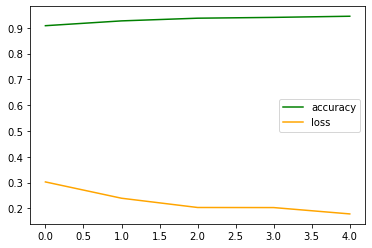

In [18]:
plt.plot(train_hist[0], color='green', label='accuracy')
plt.plot(train_hist[1], color='orange', label='loss')
plt.legend()
plt.show()

In [19]:
preds, real = validate_model(vgg_model, vgg_dl_valid, num_samples=5000)

<ipython-input-7-30ed0b62f98d>:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = F.softmax(preds)  # pass results to activate function


accuracy is 0.9408118376324736


### 1.2 Train simple CNN model

In [20]:
train_hist_cnn, valid_hist_cnn = train(model, epochs=15, optimizer=optimizer, loss_func=loss_function, train_loader=tensor_dl_train, valid_loader=None, train_frac=0.35) # 

Process 0.0%
Process 0.12189176011701609%
Process 0.24378352023403219%
Process 0.3656752803510483%
Process 0.48756704046806437%
Process 0.6094588005850805%
Process 0.7313505607020966%
Process 0.8532423208191127%
Process 0.9751340809361287%
Epoch 0. acc: 0.67564 loss: 0.56072
Process 0.0%
Process 0.12189176011701609%
Process 0.24378352023403219%
Process 0.3656752803510483%
Process 0.48756704046806437%
Process 0.6094588005850805%
Process 0.7313505607020966%
Process 0.8532423208191127%
Process 0.9751340809361287%
Epoch 1. acc: 0.88724 loss: 0.26885
Process 0.0%
Process 0.12189176011701609%
Process 0.24378352023403219%
Process 0.3656752803510483%
Process 0.48756704046806437%
Process 0.6094588005850805%
Process 0.7313505607020966%
Process 0.8532423208191127%
Process 0.9751340809361287%
Epoch 2. acc: 0.91636 loss: 0.20852
Process 0.0%
Process 0.12189176011701609%
Process 0.24378352023403219%
Process 0.3656752803510483%
Process 0.48756704046806437%
Process 0.6094588005850805%
Process 0.731350

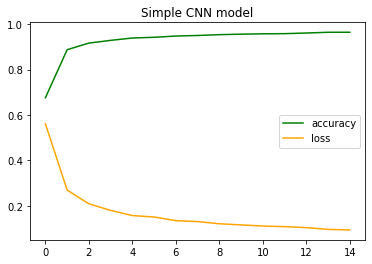

In [21]:
plt.plot(train_hist_cnn[0], color='green', label='accuracy')
plt.plot(train_hist_cnn[1], color='orange', label='loss')
plt.title("Simple CNN model")
plt.legend()
plt.show()

#### Saving models

In [23]:
torch.save(vgg_model.cpu(), 'vgg_model_trained.pt')

In [22]:
torch.save(model.cpu(), 'my_model_trained.pt')